# Importación de las librerias y carga de archivo STL

In [41]:
import numpy as np
import trimesh
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.interpolate import griddata

In [42]:
stl = int(1)  # Seleccionar el archivo STL a usar

# Diccionario con las rutas de los archivos STL
stl_paths = {
    # Gombocs
    1: r"C:\Users\david\Material Universidad\Retos\STL\Monostatic_Body_Release.STL", # Gomboc 1 con resolucion media
    2: r"C:\Users\david\Material Universidad\Retos\STL\GollyPoly.stl", # Gomboc 2 con resolucion alta
    # Archivos para confirmar el funcionamiento del algoritmo
    3: r"C:\Users\david\Material Universidad\Retos\STL\20000_polygon_sphere_100mm.STL", # Esfera
    4: r"C:\Users\David\Material Universidad\Retos\STL\Cilindro_3D.stl", # Cilindro
    5: r"C:\Users\David\Material Universidad\Retos\STL\Cubo_Prueba_20x20.stl", # Cubo
    }

# Usar el archivo correspondiente dependiendo de prueba
mesh = trimesh.load_mesh(stl_paths[stl])

# Calculo del Tensor de Inercia diagonalizado y los ejes principales de inercia

In [43]:
# Calcular el volumen, centro de masa y el tensor de inercia
volume = mesh.volume
centroid = mesh.center_mass
inertia_tensor_origin = mesh.moment_inertia  # Si se desea considerar la densidad, se multiplica por la densidad

# Asumimos densidad uniforme, entonces la masa es proporcional al volumen (usaremos volumen como masa)
mass = volume  # Se multiplica por la densidad

# Vector de traslación del centro de masa
d = centroid.reshape(3, 1)  # Convertir a columna para cálculo

# Matriz identidad 3x3
I_identity = np.eye(3)

# Producto exterior de d (d * d^T)
d_outer = np.dot(d, d.T)

# Aplicar el teorema de Steiner
inertia_tensor_cm = inertia_tensor_origin + mass * (np.trace(d_outer) * I_identity - d_outer)

print("Volumen:", volume)
print("Centro de masa:", centroid)

# Suponiendo que 'inertia_tensor' es tu tensor de inercia 3x3:
eigvals, eigvecs = np.linalg.eigh(inertia_tensor_cm)

print("Momentos principales de inercia:", eigvals)
print("Ejes principales (columnas de eigvecs):", eigvecs)

# Confirmar ortogonalidad de los ejes principales
orthogonality_check = np.allclose(np.dot(eigvecs.T, eigvecs), np.eye(3))
print("Los ejes principales son ortogonales:", orthogonality_check)

Volumen: 89212.22492407954
Centro de masa: [80.49488329 88.54194673 95.20570733]
Momentos principales de inercia: [2.84197439e+07 2.11228254e+09 2.11577913e+09]
Ejes principales (columnas de eigvecs): [[ 0.52728915  0.84472332 -0.09169877]
 [ 0.5788615  -0.4361277  -0.68899346]
 [ 0.62200122 -0.31021789  0.71894321]]
Los ejes principales son ortogonales: True


# Grafica de la malla y los eigenvectors o vectores principales de rotación

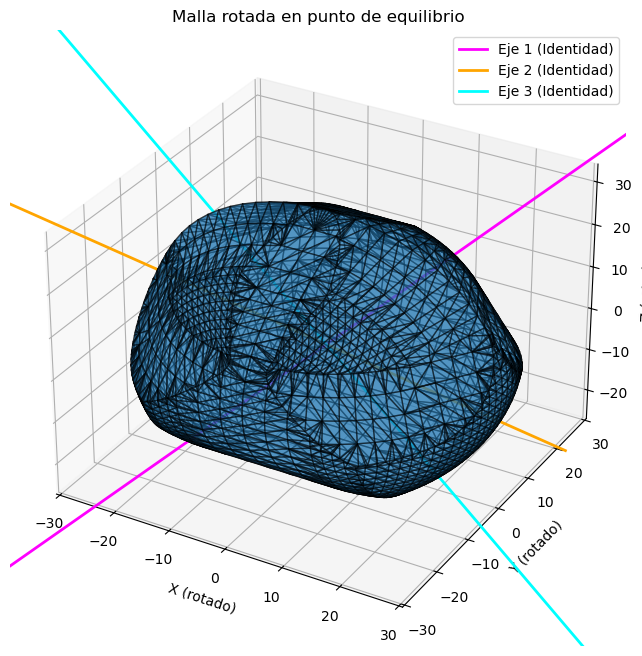

vectores propios rotados:
 [[-0.52728915 -0.09169877  0.84472332]
 [-0.5788615  -0.68899346 -0.4361277 ]
 [-0.62200122  0.71894321 -0.31021789]]


In [44]:
rotation_matrix = np.array([[-1, 0, 0],
                            [ 0, 0, 1],
                            [ 0, 1, 0]]) # Matriz de rotación

rotated_vertices = (rotation_matrix.T @ (mesh.vertices - centroid).T).T

# Crear figura 3D para la malla rotada
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Graficar la malla rotada
rotated_mesh_collection = Poly3DCollection(rotated_vertices[mesh.faces], alpha=0.5, edgecolor="k")
ax.add_collection3d(rotated_mesh_collection)

# Escalar la visualización según el tamaño de la malla rotada
max_range = np.array([rotated_vertices[:, 0].max()-rotated_vertices[:, 0].min(), 
                      rotated_vertices[:, 1].max()-rotated_vertices[:, 1].min(), 
                      rotated_vertices[:, 2].max()-rotated_vertices[:, 2].min()]).max() / 2.0
mid_x = (rotated_vertices[:, 0].max()+rotated_vertices[:, 0].min()) * 0.5
mid_y = (rotated_vertices[:, 1].max()+rotated_vertices[:, 1].min()) * 0.5
mid_z = (rotated_vertices[:, 2].max()+rotated_vertices[:, 2].min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

# Graficar las rectas generadas por los vectores de la matriz identidad
# Estos vectores son [1, 0, 0], [0, 1, 0] y [0, 0, 1]. Dibujamos una línea para cada eje.
rotated_eigvecs = (rotation_matrix.T @ eigvecs.T).T  # Rotar los vectores propios
line_length = max_range  # longitud para la representación
origin = np.array([0, 0, 0])
colors_identity = ['magenta', 'orange', 'cyan']

for i in range(3):
    vec = rotated_eigvecs[:, i]
    # Definir dos puntos a lo largo de la recta: de -line_length a line_length
    t = np.linspace(-100, 100, 2)
    line_points = np.outer(t, vec)
    ax.plot(line_points[:, 0], line_points[:, 1], line_points[:, 2], color=colors_identity[i],
            linewidth=2, label=f'Eje {i+1} (Identidad)')

# Configurar etiquetas y título
ax.set_xlabel("X (rotado)")
ax.set_ylabel("Y (rotado)")
ax.set_zlabel("Z (rotado)")
ax.set_title("Malla rotada en punto de equilibrio")

ax.legend()
plt.show()

print("vectores propios rotados:\n", rotated_eigvecs)

# Se definen los triangulos del archivo STL

In [45]:
# Obtener los vértices y caras de la malla
vertices = mesh.vertices
faces = mesh.faces

# Definicion de la posicion de los vertices de cada triangulo
V1 = vertices[faces[:, 0]]
V2 = vertices[faces[:, 1]]
V3 = vertices[faces[:, 2]]

# Calculo de los vectores normales a la superficie

In [46]:
# Producto cruzado de los lados del triángulo
normals = np.cross(V2 - V1, V3 - V1)

# Normalizar los vectores normales
normals /= np.linalg.norm(normals, axis=1, keepdims=True)

print(normals)

[[-0.32841567  0.77452338  0.5406077 ]
 [-0.42981643  0.72318684  0.5406095 ]
 [-0.4776886   0.69250267  0.54060489]
 ...
 [ 0.22626223  0.38399058 -0.89518525]
 [ 0.22626501  0.38399158 -0.89518412]
 [ 0.22626232  0.38399115 -0.89518499]]


# Calculo de los vectores desde el centro de masa a la superficie

In [47]:
midpoints = (V1 + V2 + V3) / 3  # Puntos medios de los triángulos

# Calcular los vectores desde el centro de masa a cada punto medio
vectors = midpoints - centroid

print(vectors)

[[ -9.69789385  21.89183013  12.24958442]
 [-12.12281044  20.59074879  12.24958442]
 [-13.55092374  19.64630604  12.24958442]
 ...
 [  6.35008232   8.63685576 -23.32095697]
 [  6.73496493   9.97851531 -22.64816898]
 [  7.05450941   9.97851531 -22.56740167]]


# Calculo de la altura del centro de masa

In [48]:
def altura_centro_masa(vectors, normals):
    """
    Calcula la proyección (producto punto) de cada vector sobre su correspondiente normal.
    Parámetros:
      vectors : np.ndarray de shape (N, 3)
          Vectores desde el centro de masa hasta los centros de los triángulos.
      normals : np.ndarray de shape (N, 3)
          Vectores normales (normalizados) de cada triángulo.
    Retorna:
      alturas : np.ndarray de shape (N,)
          Producto punto de cada par, que se interpretará como la "altura".
    """
    alturas = np.sum(vectors * normals, axis=1)
    return alturas

In [49]:
# Calculamos las alturas (proyecciones)
alturas = altura_centro_masa(vectors, normals)
print("Alturas (proyecciones del vector desde el centro de masa):\n", alturas)

Alturas (proyecciones del vector desde el centro de masa):
 [26.76289417 26.72378335 26.70042649 ... 25.62983181 25.62983403
 25.62983038]


# Parametrización de los vectores con respecto a theta y phi

In [ ]:
def compute_theta_phi(vectors, rotation_matrix):
    """
    Calcula los ángulos theta y phi de cada vector usando las definiciones:
      theta = arccos(z / r)
      phi   = sgn(y) * arccos(x / sqrt(x^2 + y^2))
    donde (x, y, z) son las componentes del vector en el sistema de coordenadas (e1, e2, e3).
    
    Parámetros:
      vectors : np.ndarray de shape (N, 3)
          Vectores en coordenadas cartesianas (originales).
      eigvecs : np.ndarray de shape (3, 3)
          Matriz de eigenvectores, donde cada columna es un eigenvector.

    Retorna:
      theta : np.ndarray de shape (N,)
          Ángulo polar (definición de la imagen).
      phi   : np.ndarray de shape (N,)
          Ángulo azimutal (definición de la imagen).
    """
    
    # Para cada vector, calculamos sus componentes en el sistema (e1, e2, e3)
    #   x' = v · e1
    #   y' = v · e3
    #   z' = v · e2
    x_comp = np.dot(vectors, rotation_matrix[:, 0])  # Proyección en el eje "x"
    y_comp = np.dot(vectors, rotation_matrix[:, 1])  # Proyección en el eje "y"
    z_comp = np.dot(vectors, rotation_matrix[:, 2])  # Proyección en el eje "z"
    
    # Norma de cada vector en este nuevo sistema
    r = np.sqrt(x_comp**2 + y_comp**2 + z_comp**2)
    # Para evitar división por cero
    r_safe = np.where(r == 0, 1, r)
    
    # --------------------
    # Cálculo de theta
    # --------------------
    # theta = arccos(z / r)
    # Clipeamos el argumento de arccos a [-1,1] para evitar errores numéricos
    cos_theta = z_comp / r_safe
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    theta = np.arccos(cos_theta)
    
    # --------------------
    # Cálculo de phi
    # --------------------
    # phi = sgn(y) * arccos(x / sqrt(x^2 + y^2))
    # Definimos el denominador para x^2 + y^2
    xy_norm = np.sqrt(x_comp**2 + y_comp**2)
    xy_norm_safe = np.where(xy_norm == 0, 1, xy_norm)  # evitar 0 en la división
    
    # arccos(x / sqrt(x^2 + y^2))
    arg_phi = x_comp / xy_norm_safe
    arg_phi = np.clip(arg_phi, -1.0, 1.0)  # clip para evitar fuera de dominio
    base_phi = np.arccos(arg_phi)
    
    # sgn(y)
    sgn_y = np.sign(y_comp)
    
    # Producto final
    phi = sgn_y * base_phi
    
    return theta, phi

In [51]:
# Parametrización
theta, phi = compute_theta_phi(vectors, rotation_matrix)
print("Theta:", min(theta), max(theta))
print("Phi:", min(phi), max(phi))

Theta: 0.032067506344798644 3.078754650498231
Phi: -3.1411962695538667 3.141592234498774


# Gráfica proporcional del potencial gravitacional

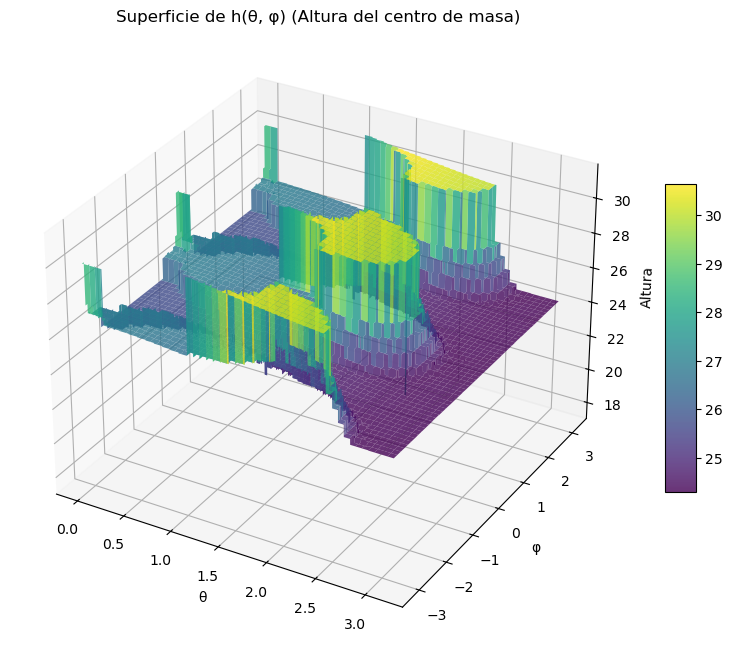

In [52]:
# --- INTERPOLACIÓN PARA GRAFICAR COMO SUPERFICIE ---
# Se asume que theta está en [0, π] y phi en [-π, π].
theta_lin = np.linspace(0, np.pi, 10000)
phi_lin = np.linspace(-np.pi, np.pi, 20000)
theta_grid, phi_grid = np.meshgrid(theta_lin, phi_lin)

# Interpolar los valores de alturas (dispersos) sobre la malla regular.
points = np.column_stack((theta, phi))
grid_alturas = griddata(points, alturas, (theta_grid, phi_grid), method='nearest')

# Definir los límites de Z
z_min, z_max = min(alturas), max(alturas) + 1

# Filtrar valores fuera del rango deseado
grid_alturas[(grid_alturas < z_min) | (grid_alturas > z_max)] = np.nan  # Convertirlos en NaN

# --- GRAFICAR LA SUPERFICIE ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar sin los valores fuera de zlim
surf = ax.plot_surface(theta_grid, phi_grid, grid_alturas, cmap='viridis', edgecolor='none', alpha=0.8)

ax.set_xlabel("θ")
ax.set_ylabel("φ")
ax.set_zlabel("Altura")
ax.set_zlim(z_min, z_max)
ax.set_title("Superficie de h(θ, φ) (Altura del centro de masa)")
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()